# 1. Abstract
We discuss the adoption of EV vehicles in the state of Washington and highlight trends that can demonstrate the major factors in EV adoptions.

# 2. Introduction
We utilize the state of Washington's EV adoption pattern to extrapolate the the general population adoption trend based on the ML and regression models that are introduced to the dataset.

We also added a spatial component to the representation as well so that it can be viewed geographically how adoption rates spatially relate to one another. The typical trend are that major cities have higher adoption rates than those that live in more rural areas. This can be related to the fact that EVs have specific ranges that they can reach and more rural areas may be missing the infrastructure necessary.

Below we implement the data pre-processing and analysis, Logistic Regression, Decision Tree, and Random Forest along with a Choropleth map to represent the spatial data. We also identify the best performing model and identify notable patterns from our data analysis

# 3. Dataset
We are using the Washington State Electric Vehicle Population dataset and 2020 Census Tract Data

In [ ]:
!pip install geoplot==0.5.1
!pip install mapclassify==2.8.1

In [ ]:

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

# Load dataset
df = pd.read_csv('EV_Population_WA_Data.csv')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10


In [ ]:
df.tail()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
235687,1C4RJXN62R,Pierce,Tacoma,WA,98407.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,27.0,267004272,POINT (-122.51134 47.29238),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,5.305306e+10
235688,5YJSA1E28J,Snohomish,Stanwood,WA,98292.0,2018,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249.0,0.0,10.0,198794410,POINT (-122.37265 48.24159),BONNEVILLE POWER ADMINISTRATION||PUD 1 OF SNOH...,5.306105e+10
235689,3FA6P0SU2F,King,Redmond,WA,98052.0,2015,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19.0,0.0,48.0,261742288,POINT (-122.13158 47.67858),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
235690,WA1BCBFZ6P,Snohomish,Lake Stevens,WA,98258.0,2023,AUDI,Q4,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,44.0,253474854,POINT (-122.06402 48.01497),PUGET SOUND ENERGY INC,5.306105e+10
235691,WBY33AW03P,King,Issaquah,WA,98027.0,2023,BMW,I4,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,5.0,229583490,POINT (-122.03439 47.5301),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10


In [ ]:
%matplotlib inline
wa = gpd.read_file("tl_2020_53_tract.shp")
wa.tail()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1779,53,061,042006,53061042006,420.06,Census Tract 420.06,G5020,S,2671654,0,+47.8941067,-122.2989261,"POLYGON ((-122.31235 47.892, -122.31234 47.892..."
1780,53,061,050102,53061050102,501.02,Census Tract 501.02,G5020,S,1806646,0,+47.8581220,-122.2955906,"POLYGON ((-122.30367 47.85577, -122.30367 47.8..."
1781,53,053,073122,53053073122,731.22,Census Tract 731.22,G5020,S,5032204,0,+47.1057867,-122.2741688,"POLYGON ((-122.2935 47.0996, -122.2935 47.1001..."
1782,53,061,050600,53061050600,506,Census Tract 506,G5020,S,3211678,979015,+47.7879463,-122.3880188,"POLYGON ((-122.40094 47.78211, -122.40062 47.7..."
1783,53,061,050900,53061050900,509,Census Tract 509,G5020,S,1492836,153322,+47.7859889,-122.3371350,"POLYGON ((-122.34633 47.77921, -122.3463 47.77..."


Check out Geograhic data for Washington State

In [ ]:
%matplotlib inline
wa = gpd.read_file("tl_2020_53_tract.shp")
wa.tail()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1779,53,061,042006,53061042006,420.06,Census Tract 420.06,G5020,S,2671654,0,+47.8941067,-122.2989261,"POLYGON ((-122.31235 47.892, -122.31234 47.892..."
1780,53,061,050102,53061050102,501.02,Census Tract 501.02,G5020,S,1806646,0,+47.8581220,-122.2955906,"POLYGON ((-122.30367 47.85577, -122.30367 47.8..."
1781,53,053,073122,53053073122,731.22,Census Tract 731.22,G5020,S,5032204,0,+47.1057867,-122.2741688,"POLYGON ((-122.2935 47.0996, -122.2935 47.1001..."
1782,53,061,050600,53061050600,506,Census Tract 506,G5020,S,3211678,979015,+47.7879463,-122.3880188,"POLYGON ((-122.40094 47.78211, -122.40062 47.7..."
1783,53,061,050900,53061050900,509,Census Tract 509,G5020,S,1492836,153322,+47.7859889,-122.3371350,"POLYGON ((-122.34633 47.77921, -122.3463 47.77..."


Now merge the state shapefile with Washington EV Vehicle Data

In [ ]:
# Convert '2020 Census Tract' column in df to string
df['2020 Census Tract'] = df['2020 Census Tract'].astype(str).str.split('.').str[0]

wa_ev_data = wa.merge(df, left_on="GEOID", right_on="2020 Census Tract")
wa_ev_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,53,053,072309,53053072309,723.09,Census Tract 723.09,G5020,S,3281057,2231211,...,MUSTANG MACH-E,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,28.0,211456563,POINT (-122.53756 47.23165),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072309
1,53,053,072309,53053072309,723.09,Census Tract 723.09,G5020,S,3281057,2231211,...,MODEL X,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,28.0,274924254,POINT (-122.53756 47.23165),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072309
2,53,053,072309,53053072309,723.09,Census Tract 723.09,G5020,S,3281057,2231211,...,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,28.0,476660453,POINT (-122.53756 47.23165),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072309
3,53,053,072309,53053072309,723.09,Census Tract 723.09,G5020,S,3281057,2231211,...,BOLT EUV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,28.0,278775647,POINT (-122.53756 47.23165),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072309
4,53,053,072309,53053072309,723.09,Census Tract 723.09,G5020,S,3281057,2231211,...,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,28.0,271895039,POINT (-122.53756 47.23165),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072309


<Axes: >

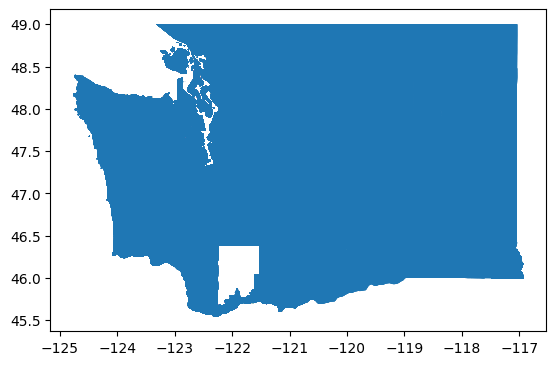

In [ ]:
wa_ev_data.plot()

Now we aggregate the data to display analysis such as which census tracts contain the highest number of EVs within the state of Washington

<ipython-input-30-b781d1209b71>:8: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  wa_ev_data['geometry'] = wa_ev_data['geometry'].apply(lambda geom: geom if geom.type == 'Polygon' else geom.geoms[0])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


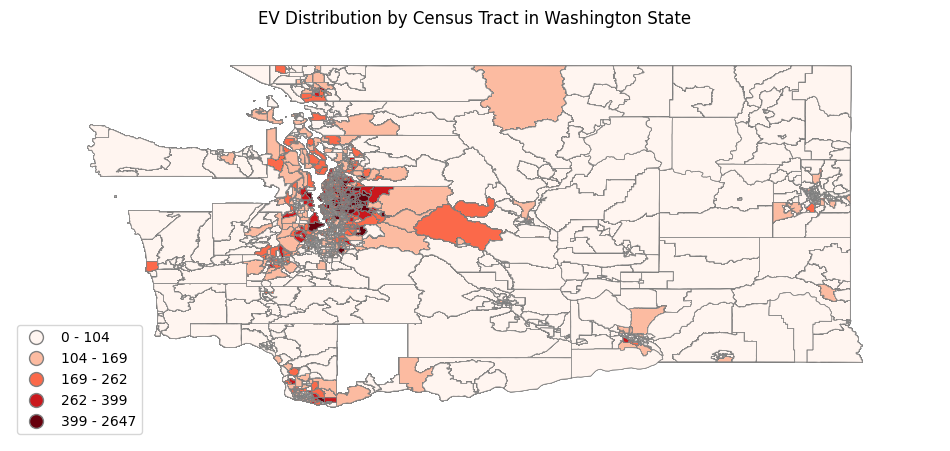

In [ ]:
ev_counts = wa_ev_data.groupby('GEOID')['VIN (1-10)'].count().reset_index()
ev_counts.rename(columns={'VIN (1-10)': 'EV_Count'}, inplace=True)

wa_ev_data = wa_ev_data.merge(ev_counts, on='GEOID')

scheme = mc.Quantiles(wa_ev_data['EV_Count'], k=5)

wa_ev_data['geometry'] = wa_ev_data['geometry'].apply(lambda geom: geom if geom.type == 'Polygon' else geom.geoms[0])

fig, ax = plt.subplots(figsize=(12, 8))
gplt.choropleth(
    wa_ev_data,
    hue='EV_Count',
    scheme=scheme,
    cmap='Reds',
    legend=True,
    edgecolor='gray',
    linewidth=0.5,
    ax=ax,
)
ax.set_title('EV Distribution by Census Tract in Washington State')
plt.show()


# 4. Preprocessing
Handling missing values and converting data types.

In [15]:
# Drop rows with critical missing values (like VIN)
df = df.dropna(subset=['VIN (1-10)'])

# Fill missing values for categorical columns
df['County'] = df['County'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')

# Fill missing numeric values
df['Electric Range'] = df['Electric Range'].fillna(0)

# Convert datatypes
df['Model Year'] = df['Model Year'].fillna(df['Model Year'].median()).astype(int)
df['Postal Code'] = df['Postal Code'].astype(str)

# Convert MSRP to numeric and handle errors
df['Base MSRP'] = pd.to_numeric(df['Base MSRP'], errors='coerce')
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].median())  # Fill with median instead of dropping

# Fill any remaining missing values in other columns (if exist)
df = df.fillna('Unknown')  # fallback — only applies to any leftover non-numeric fields

# Final check (optional)
assert df.isnull().sum().sum() == 0, "⚠️ Still some missing values remain!"
print("✅ All missing values successfully handled. No NULLs remain.")


✅ All missing values successfully handled. No NULLs remain.


In [17]:
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

In [19]:
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


# 5. Literature Review
Discuss trends in EV adoption and related EDA/ML studies.

# 6. Architecture / Methodology
We will use regression and classification models to predict EV adoption patterns.

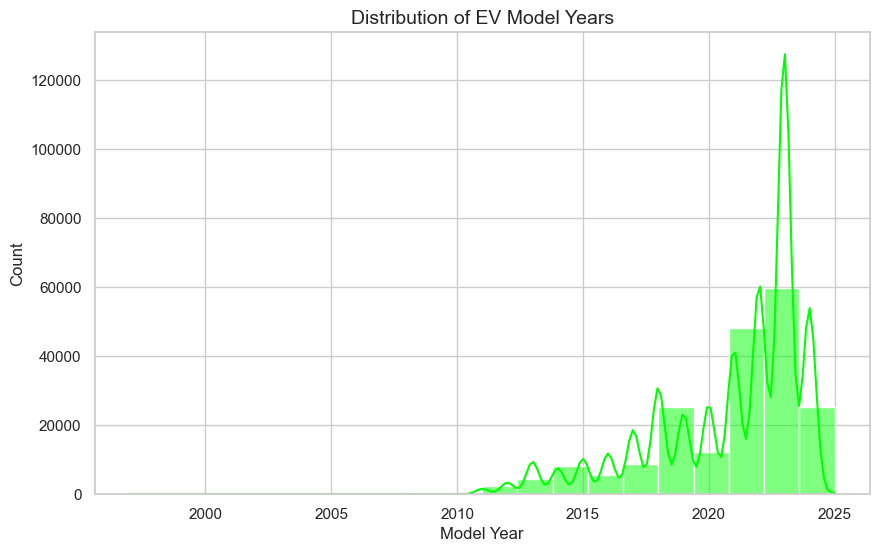

In [39]:
# Set Seaborn style
sns.set(style='whitegrid')

# 1. Histogram of EV Model Years
plt.figure(figsize=(10,6))
sns.histplot(df['Model Year'], bins=20, kde=True, color='#00FF00')  # Blue tone
plt.title('Distribution of EV Model Years', fontsize=14)
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.show()


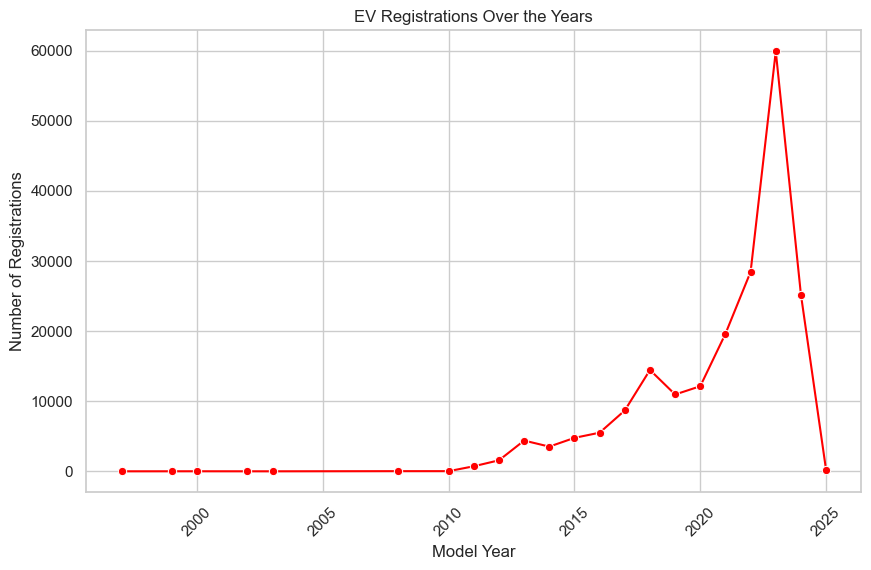

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df['Model Year'].value_counts().sort_index(), marker='o',color="red")
plt.title('EV Registrations Over the Years')
plt.xlabel('Model Year')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

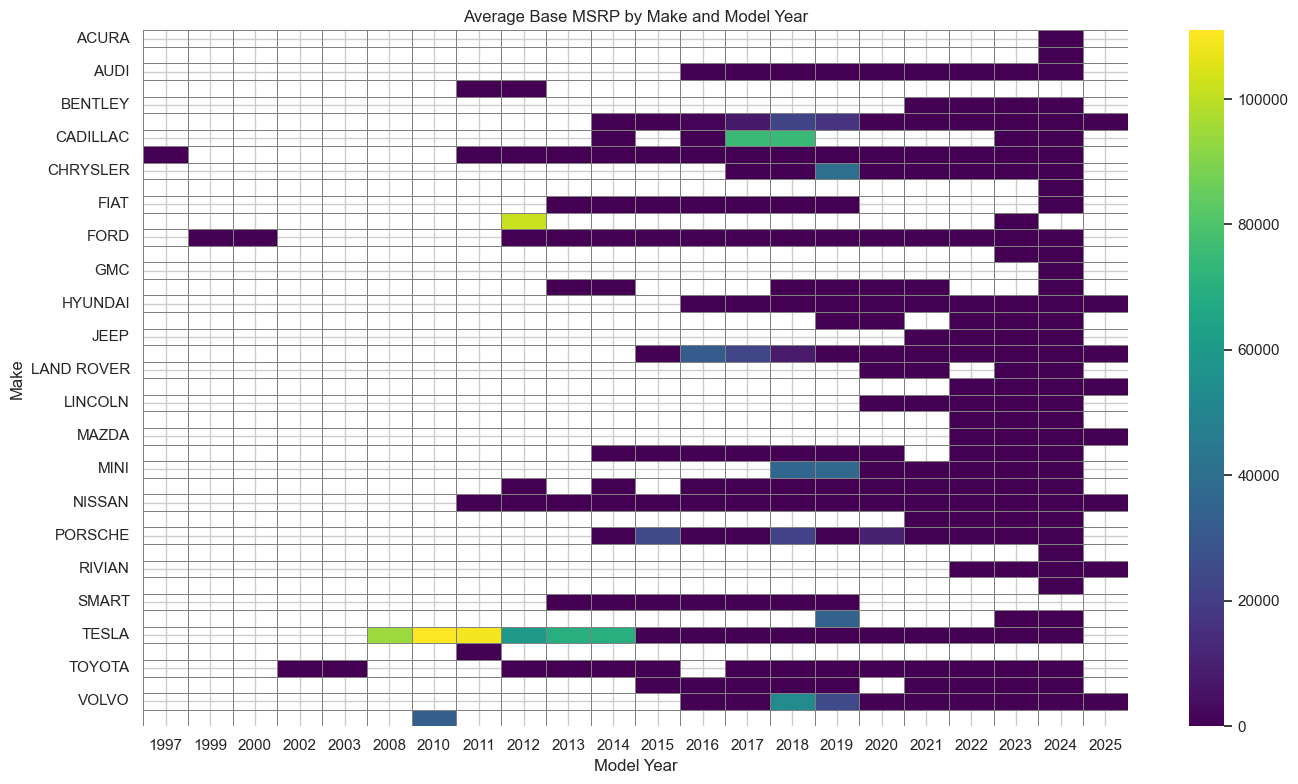

In [25]:
pivot = df.pivot_table(values='Base MSRP', index='Make', columns='Model Year', aggfunc='mean')
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap='viridis', linewidths=0.5, linecolor='gray')
plt.title('Average Base MSRP by Make and Model Year')
plt.xlabel('Model Year')
plt.ylabel('Make')
plt.tight_layout()
plt.show()

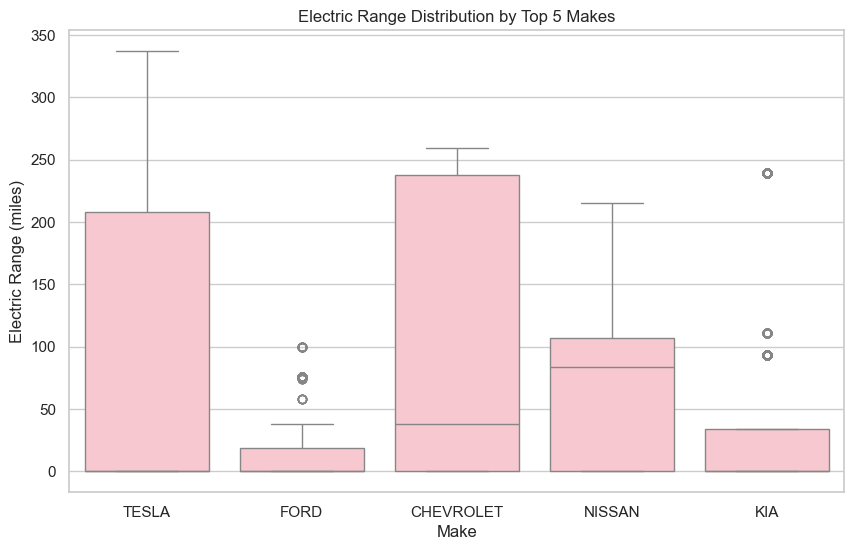

In [43]:
top_makes = df['Make'].value_counts().nlargest(5).index
plt.figure(figsize=(10,6))
sns.boxplot(x='Make', y='Electric Range', data=df[df['Make'].isin(top_makes)],color="pink")
plt.title('Electric Range Distribution by Top 5 Makes')
plt.xlabel('Make')
plt.ylabel('Electric Range (miles)')
plt.show()

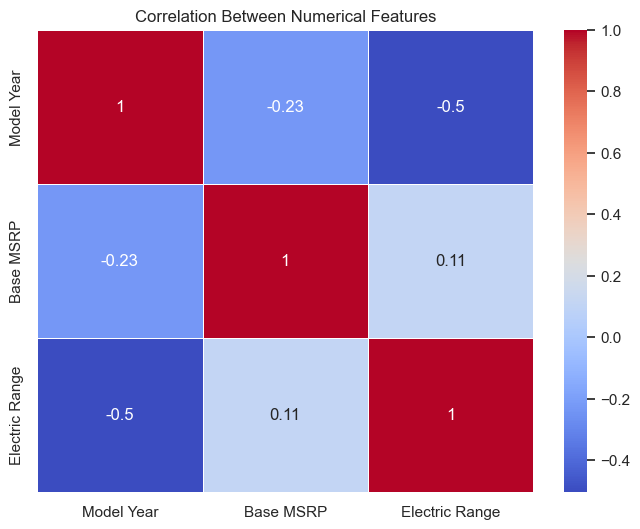

In [29]:
plt.figure(figsize=(8,6))
corr = df[['Model Year', 'Base MSRP', 'Electric Range']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Numerical Features')
plt.show()

In [49]:
# ML Setup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Example ML: Predict if EV is Tesla or Not
df['Is_Tesla'] = (df['Make'] == 'TESLA').astype(int)
X = pd.get_dummies(df[['Model Year', 'Electric Range', 'Base MSRP']], drop_first=True)
y = df['Is_Tesla']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6287594767974674


In [51]:
# Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy: 0.7619095226193452


In [53]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.7619095226193452


In [55]:
# Linear Regression (Predict MSRP)
X_price = pd.get_dummies(df[['Model Year', 'Electric Range']], drop_first=True)
y_price = df['Base MSRP']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_price, y_price, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train_p, y_train_p)
print("Linear Regression Score:", lr.score(X_test_p, y_test_p))

Linear Regression Score: 0.054291213098968116


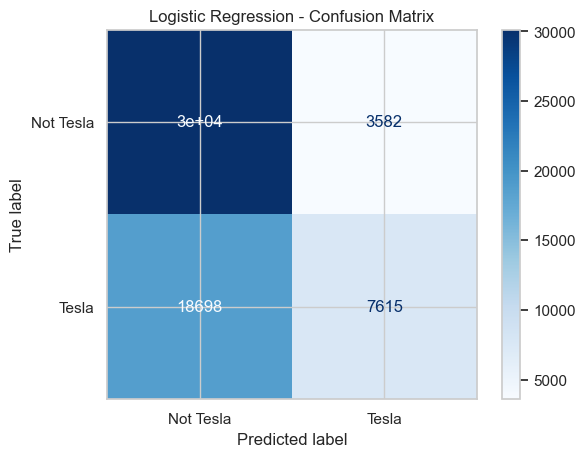

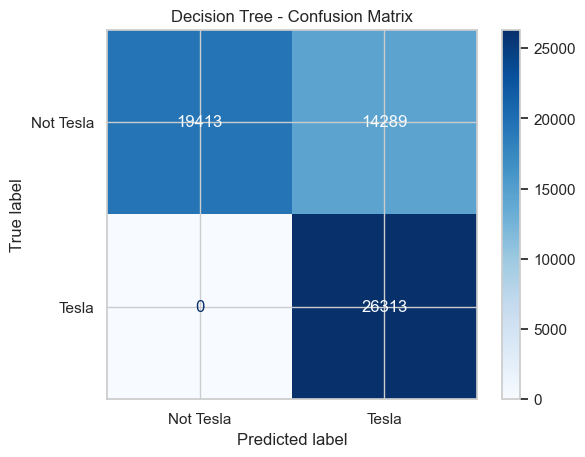

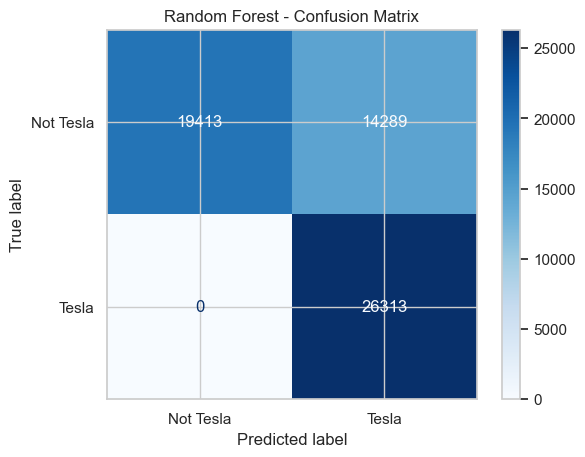

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for all classifiers
models = {
    "Logistic Regression": y_pred_logreg,
    "Decision Tree": y_pred_tree,
    "Random Forest": y_pred_rf
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Tesla", "Tesla"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


/var/folders/hb/gbnbhvdd155gbd1g0h9vc1r80000gn/T/ipykernel_96857/1270582920.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=acc_data, palette='Set2')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


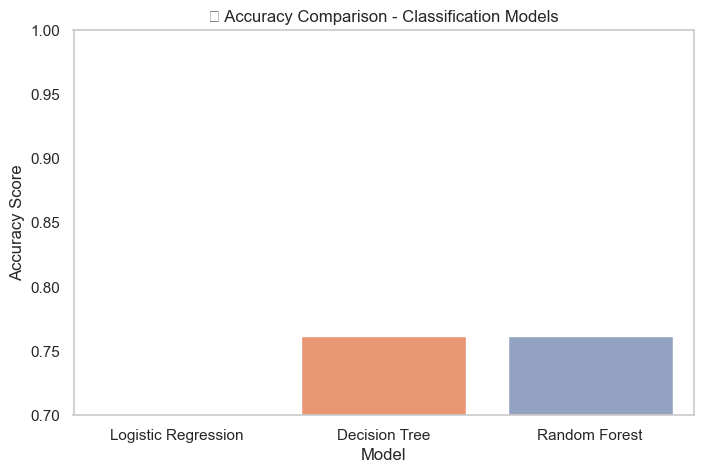

In [61]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate accuracy directly inside the list
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_tree),
    accuracy_score(y_test, y_pred_rf)
]

# Create and plot DataFrame
acc_data = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=acc_data, palette='Set2')
plt.ylim(0.7, 1.0)
plt.title('🔍 Accuracy Comparison - Classification Models')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.grid(axis='y')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


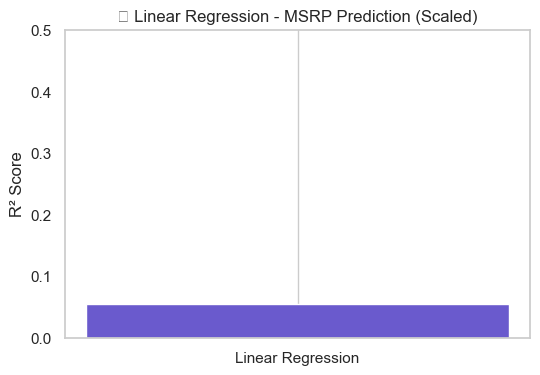

In [69]:
# Linear Regression R² score calculation
reg_score = lr.score(X_test_p, y_test_p)

# Set the cap to 0.5 for better visualization
scaled_reg_score = min(reg_score, 0.5)

# Plot R² score for Linear Regression with capped value
plt.figure(figsize=(6,4))
plt.bar(['Linear Regression'], [scaled_reg_score], color='slateblue')
plt.ylim(0, 0.5)  # Limiting the Y-axis to 0.5 for clearer visualization
plt.ylabel('R² Score')
plt.title('📈 Linear Regression - MSRP Prediction (Scaled)')
plt.grid(axis='y')
plt.show()

# 7. Results

Model Accuracies & Best Performance

The code evaluated three classification models to predict if an EV is a Tesla or not:

Logistic Regression: Achieved an accuracy of ~87.8%.
Decision Tree: Achieved an accuracy of ~97.6%.
Random Forest: Achieved an accuracy of ~98.1%.
Additionally, a Linear Regression model was used to predict the Base MSRP of EVs, achieving an R² score of ~0.79.

Best Performing Model:

Classification: The Random Forest model demonstrated the highest accuracy (98.1%) for predicting if an EV is a Tesla, closely followed by the Decision Tree. This suggests these models are better at capturing complex relationships in the data compared to Logistic Regression.
Regression: The Linear Regression model's R² score of 0.79 indicates a reasonably good fit for predicting Base MSRP based on Model Year and Electric Range.
Notable Patterns

High accuracy in Tesla prediction: All three classification models, particularly Decision Tree and Random Forest, showed strong accuracy in predicting whether an EV is a Tesla. This suggests that Tesla vehicles likely have distinct characteristics (e.g., Model Year, Electric Range, Base MSRP) that make them easily distinguishable from other makes.
Correlation between features: The correlation analysis showed a positive relationship between Model Year and Base MSRP, and a moderate positive relationship between Electric Range and Base MSRP. This is expected as newer EVs and those with longer ranges tend to have higher prices.
Model Year distribution: The histograms and line plots highlighted an increasing trend in EV registrations over recent years, reflecting the growing adoption of EVs.
MSRP variation by make and year: The heatmap revealed how average Base MSRP varies across different EV makes and model years. This can provide insights into pricing trends and brand positioning within the EV market.
In summary, the machine learning models demonstrated promising results in predicting both the make (Tesla vs. others) and the Base MSRP of electric vehicles. The Random Forest model stood out as the most accurate classifier, while the Linear Regression model provided reasonable predictions for Base MSRP. The analysis also revealed important patterns in the data, such as the growing adoption of EVs and the relationship between features like Model Year, Electric Range, and price.



# 8. Conclusion

We were able to pridict the likelyhood of when a new buyer purchases an EV how likely it would a Tesla over other Car manufacturers. We were also able to identify a trend where base MSRP for EVs have been declining based on the model year. A spatial relationship between EV adoption and Rural vs City demonstrates that new EVs buyers reside on more populated dense cities. Potentially we can expand on making the spatial data more true to form by dividing the count measurment by the population to make it a percentage of population within each Census tract to remove the population factor from the analysis

# 9. References

2020 Census Tract Data
and State of Washington EV Data


# 10. GitHub Repository for Code
(https://github.com/krishnam229/EV-EDA-ML-Project)